###### 由于favorite是目前比较有用的feature。这里需要总结几个目前想到的特征: 
1. 根据entiti去总结出被引用最多的50种entitie，然后算他们出现时的retweet
2. 根据hashtage总结出引用最多的50种hashtag，然后他们出现时的retweet
3. 根据favorite筛选出其中的最大值以及最小值
4. 根据favorite选出最常搭配的10个entitie，10个hashtag

In [75]:
#invite people for the Kaggle party
import os
import gc
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
from datetime import datetime
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [78]:
from config import INPUT_PATH, OUTPUT_PATH, SAMPLE_PATH, RANDOM_STATE, THREADS

In [2]:
ROOT_PATH = '/home/chai/Projects/CIKM2020'
# INPUT_PATH = os.path.join(ROOT_PATH, 'public_dat_50027')
INPUT_PATH = os.path.join(ROOT_PATH, 'sample_data')

In [3]:
#get the column
feature_name = pd.read_table(os.path.join(INPUT_PATH, 'feature.name'), sep='\t')

In [4]:
# read the train data and train solution
X_train_list = []
with open(os.path.join(INPUT_PATH, 'train.data'), 'r') as f:
    for line in f.readlines():
        X_train_list.append(line.strip('\n').split('\t'))

In [5]:
#read the solution
y_train_list = []
with open(os.path.join(INPUT_PATH, 'train.solution'), 'r') as f:
    for line in f.readlines():
        y_train_list.append([line.strip('\n')])

In [6]:
X_valid_list = []
with open(os.path.join(INPUT_PATH, 'validation.data'), 'r') as f:
    for line in f.readlines():
        X_valid_list.append(line.strip('\n').split('\t'))

In [7]:
X_test_list = []
with open(os.path.join(INPUT_PATH, 'test.data'), 'r') as fin:
    for line in fin:
        X_test_list.append([0] + line.strip('\n').split('\t'))

In [8]:
X_data = pd.DataFrame(X_train_list + X_valid_list + X_test_list, columns=feature_name.columns.tolist())
y_train = np.array(y_train_list).astype(np.float32)
num_of_train, num_of_valid, num_of_test = len(X_train_list), len(X_valid_list), len(X_test_list)

del X_train_list, X_valid_list, y_train_list
gc.collect()

0

In [9]:
start_day = datetime.strptime('2019-09-30', '%Y-%m-%d')
timestamp = [datetime.strptime(tim, '%a %b %d %H:%M:%S +0000 %Y') for tim in X_data['timestamp']]
X_data['year'] = [dat.year for dat in timestamp]
X_data['month'] = [dat.month for dat in timestamp]
X_data['weekday'] = [dat.weekday() for dat in timestamp]
X_data['day'] = [dat.day for dat in timestamp]
X_data['hour'] = [dat.hour for dat in timestamp]
X_data['timestamp'] = [(dat - start_day).days for dat in timestamp]

In [10]:
X_data['sentiment_left'] = X_data['sentiment'].map(lambda x: int(x.split(' ')[0]))
X_data['sentiment_right'] = X_data['sentiment'].map(lambda x: int(x.split(' ')[1]))
X_data['sentiment_sum'] = X_data['sentiment_left'] + X_data['sentiment_right']
X_data['sentiment_sumabs'] = (X_data['sentiment_left'] + X_data['sentiment_right']).map(
    lambda x: abs(x))
X_data['sentiment_diff'] = X_data['sentiment_left'] - X_data['sentiment_right']
X_data['sentiment_div'] = X_data['sentiment_left'] / X_data['sentiment_right']

In [11]:
# entities
entities_mean = []
for each_entity in X_data['entities']:
    if each_entity != 'null;':
        tmp = []
        for each in each_entity.strip(';').split(';'):
            tmp.append(float(each.split(':')[-1]))
        entities_mean.append(np.mean(tmp))
    else:
        entities_mean.append(0)
X_data['entities_mean'] = entities_mean

entities_max = []
for each_entity in X_data['entities']:
    if each_entity != 'null;':
        tmp = []
        for each in each_entity.strip(';').split(';'):
            tmp.append(float(each.split(':')[-1]))
        entities_max.append(max(tmp))
    else:
        entities_max.append(0)
X_data['entities_max'] = entities_max

entities_min = []
for each_entity in X_data['entities']:
    if each_entity != 'null;':
        tmp = []
        for each in each_entity.strip(';').split(';'):
            tmp.append(float(each.split(':')[-1]))
        entities_min.append(max(tmp))
    else:
        entities_min.append(0)
X_data['entities_min'] = entities_min

entities_std = []
for each_entity in X_data['entities']:
    if each_entity != 'null;':
        tmp = []
        for each in each_entity.strip(';').split(';'):
            tmp.append(float(each.split(':')[-1]))
        entities_std.append(np.std(tmp))
    else:
        entities_std.append(0)
X_data['entities_std'] = entities_std

entities_len = []
for each_entity in X_data['entities']:
    if each_entity != 'null;':
        entities_len.append(len(each_entity.strip(';').split(';')))
    else:
        entities_len.append(0)
X_data['entities_len'] = entities_len

In [12]:
mentions_count_dict = {}
for each_mention in X_data['mentions']:
    if each_mention != 'null;':
        for each in each_mention.strip().split(' '):
            mentions_count_dict[each] = mentions_count_dict.get(each, 0) + 1

mentions_len = []
for each_mention in X_data['mentions']:
    if each_mention != 'null;':
        mentions_len.append(len(each_mention.split(' ')))
    else:
        mentions_len.append(0)
X_data['mentions_len'] = mentions_len

mentions_value = []
for each_mention in X_data['mentions']:
    if each_mention != 'null;':
        tmp = 0
        for each in each_mention.strip().split(' '):
            tmp += mentions_count_dict[each]
        mentions_value.append(tmp)
    else:
        mentions_value.append(0)
X_data['mentions_value'] = mentions_value

In [13]:
hashtags_count_dict = {}
for each_hashtag in X_data['hashtags']:
    if each_hashtag != 'null;':
        for each in each_hashtag.strip().split(' '):
            hashtags_count_dict[each] = hashtags_count_dict.get(each, 0) + 1

hashtags_len = []
for each_hashtag in X_data['hashtags']:
    if each_hashtag != 'null;':
        hashtags_len.append(len(each_hashtag.split(' ')))
    else:
        hashtags_len.append(0)
X_data['hashtags_len'] = hashtags_len

hashtags_value = []
for each_hashtag in X_data['hashtags']:
    if each_hashtag != 'null;':
        tmp = 0
        for each in each_hashtag.strip().split(' '):
            tmp += hashtags_count_dict[each]
        hashtags_value.append(tmp)
    else:
        hashtags_value.append(0)
X_data['hashtags_value'] = hashtags_value

In [14]:
X_data['urls_count'] = X_data['urls'].map(lambda x: 1 if x != 'null;' else 0)

In [15]:
X_data['#followers'] = X_data['#followers'].astype(int)
X_data['#friends'] = X_data['#friends'].astype(int)
X_data['#favorites'] = X_data['#favorites'].astype(int)

In [16]:
used_feature = ['timestamp', '#followers', '#friends', '#favorites', 'weekday', 'month', 'day', 'hour',
                'sentiment_left', 'sentiment_right', 'sentiment_sum', 'sentiment_sumabs', 'sentiment_diff',
                'sentiment_div', 'entities_mean', 'entities_max', 'entities_min', 'entities_std', 'entities_len',
                'mentions_len', 'mentions_value', 'hashtags_len', 'hashtags_value', 'urls_count']

train_data = pd.concat([X_data[:num_of_train], pd.DataFrame(np.log(1.0 + y_train), columns=['solution'])], axis=1)
X_valid = X_data[num_of_train:num_of_train+num_of_valid]
X_test = X_data[num_of_train+num_of_valid:]

## 开始分析

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629612 entries, 0 to 1629611
Data columns (total 33 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   tweet_id          1629612 non-null  object 
 1   username          1629612 non-null  object 
 2   timestamp         1629612 non-null  int64  
 3   #followers        1629612 non-null  int64  
 4   #friends          1629612 non-null  int64  
 5   #favorites        1629612 non-null  int64  
 6   entities          1629612 non-null  object 
 7   sentiment         1629612 non-null  object 
 8   mentions          1629612 non-null  object 
 9   hashtags          1629612 non-null  object 
 10  urls              1629612 non-null  object 
 11  year              1629612 non-null  int64  
 12  month             1629612 non-null  int64  
 13  weekday           1629612 non-null  int64  
 14  day               1629612 non-null  int64  
 15  hour              1629612 non-null  int64  
 16  

In [18]:
train_data.nunique()

tweet_id            1629612
username            1047946
timestamp               214
#followers           232647
#friends              54843
#favorites             9257
entities             591913
sentiment                25
mentions             454428
hashtags             301518
urls                 367983
year                      2
month                     8
weekday                   7
day                      31
hour                     24
sentiment_left            5
sentiment_right           5
sentiment_sum             9
sentiment_sumabs          5
sentiment_diff            9
sentiment_div            19
entities_mean        580679
entities_max         115498
entities_min         115498
entities_std         511161
entities_len             29
mentions_len             52
mentions_value        14879
hashtags_len             37
hashtags_value        30525
urls_count                2
solution               4639
dtype: int64

In [19]:
# username
username_count = {}
for name in train_data['username']:
    username_count[name] = username_count.get(name, 0) + 1
sorted_username_count = sorted(username_count.items(), key=lambda xx:xx[1])
print(sorted_username_count[-10:])

[('29fc6f98710433e0e0cada38c8c4802a', 588), ('ad65862cf68352c98f06b38747f775e9', 671), ('3d755542a70a06d6dfd2533be9534629', 676), ('902fbdd2b1df0c4f70b4a5d23525e932', 715), ('bf4571b94429c5b18e0a219c197a56a4', 782), ('f5d7e2532cc9ad16bc2a41222d76f269', 858), ('090264f1888056a96f32ccb7d91ba4e7', 940), ('4ff35e52034daec0251f7b3370969a1a', 1089), ('2435a45b85628172c5a47122144a7c67', 1236), ('7513717dba8b208fe06799dcc54e59e2', 1459)]


In [20]:
train_data.loc[train_data['username'] == '29fc6f98710433e0e0cada38c8c4802a']

,tweet_id,username,timestamp,#followers,#friends,#favorites,entities,sentiment,mentions,hashtags,...,entities_max,entities_min,entities_std,entities_len,mentions_len,mentions_value,hashtags_len,hashtags_value,urls_count,solution
10557,1181600213053652995,29fc6f98710433e0e0cada38c8c4802a,8,44238345,900,236,shenzhen:Shenzhen:-1.5176590471602702;firestor...,2 -1,null;,null;,...,-1.517659,-1.517659,0.492790,4,0,0,0,0,1,4.532599
14563,1188364734330032129,29fc6f98710433e0e0cada38c8c4802a,27,44377908,894,372,sms:SMS:-2.3289229359016232;endangered:Endange...,1 -1,null;,null;,...,-2.328923,-2.328923,0.277831,2,0,0,0,0,1,4.770685
25331,1181038477040918533,29fc6f98710433e0e0cada38c8c4802a,7,44233273,900,576,null;,1 -3,null;,null;,...,0.000000,0.000000,0.000000,0,0,0,0,0,1,5.855072
26907,1188521353797947393,29fc6f98710433e0e0cada38c8c4802a,27,44382887,894,1204,null;,1 -1,null;,null;,...,0.000000,0.000000,0.000000,0,0,0,0,0,1,6.683361
37594,1180694428039700480,29fc6f98710433e0e0cada38c8c4802a,6,44225866,900,470,flu season:Flu_season:-2.6876083078658444;,1 -2,null;,null;,...,-2.687608,-2.687608,0.000000,1,0,0,0,0,1,5.877736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614113,1249583120585809920,29fc6f98710433e0e0cada38c8c4802a,196,46167623,900,6,null;,1 -4,null;,null;,...,0.000000,0.000000,0.000000,0,0,0,0,0,1,1.609438
1621824,1247255627266764806,29fc6f98710433e0e0cada38c8c4802a,189,46060523,899,51,null;,2 -3,null;,null;,...,0.000000,0.000000,0.000000,0,0,0,0,0,1,2.995732
1621915,1247338314937630725,29fc6f98710433e0e0cada38c8c4802a,190,46065509,899,54,quarantine:Quarantine:-2.3096035868012508;,1 -1,null;,null;,...,-2.309604,-2.309604,0.000000,1,0,0,0,0,1,3.526361
1627358,1253134022525554689,29fc6f98710433e0e0cada38c8c4802a,206,46311968,904,255,joe s violin:Joe%27s_Violin:-1.943159070368447...,1 -1,null;,null;,...,-1.943159,-1.943159,0.133788,2,0,0,0,0,1,4.442651


username是具有大量重复的，有的人爱发推特，可能也会影响转发

In [21]:
df = train_data[['tweet_id', 'username', 'timestamp', 'year', 'month', 'day', 'hour']]
df = df.sort_values(by=['timestamp', 'hour'])
past_id = 0
for each_id in df['tweet_id']:
    if int(each_id) < past_id:
        print('Not increase!')
        break

根据上述实验可知，tweet_id是根据时间增长的。后期可以检查一下是否有时间的特性

In [22]:
used_feature = ['timestamp', '#followers', '#friends', '#favorites', 'weekday', 'month', 'day', 'hour',
                'sentiment_left', 'sentiment_right', 'sentiment_sum', 'sentiment_sumabs', 'sentiment_diff',
                'sentiment_div', 'entities_mean', 'entities_max', 'entities_min', 'entities_std', 'entities_len',
                'mentions_len', 'mentions_value', 'hashtags_len', 'hashtags_value', 'urls_count']

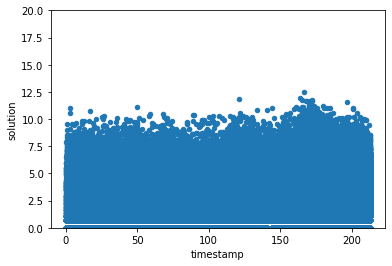

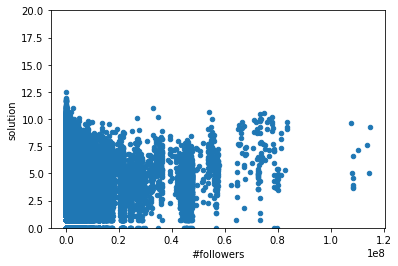

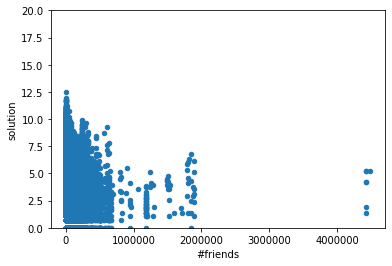

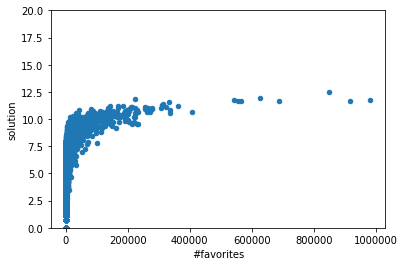

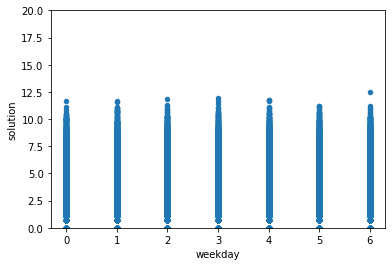

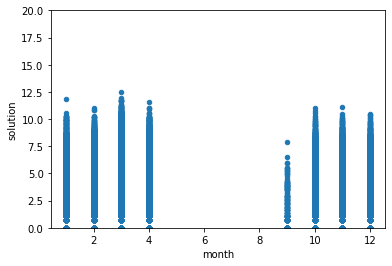

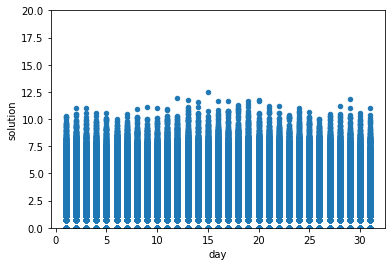

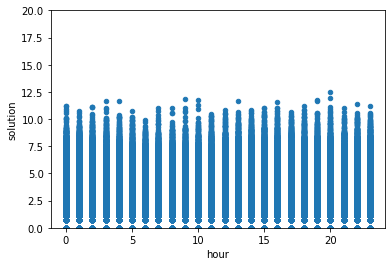

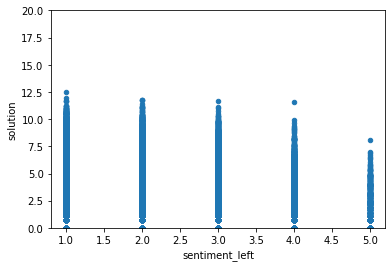

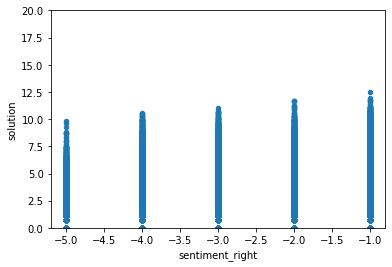

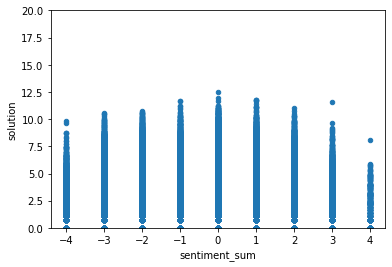

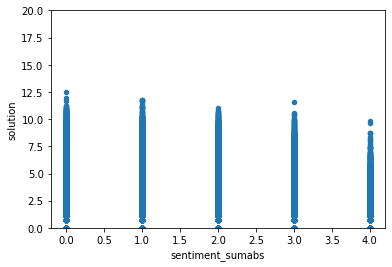

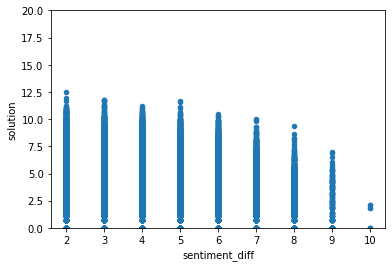

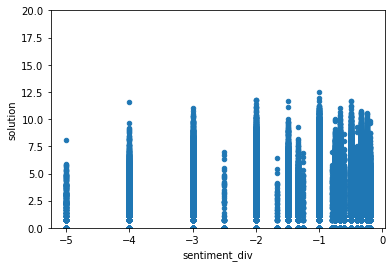

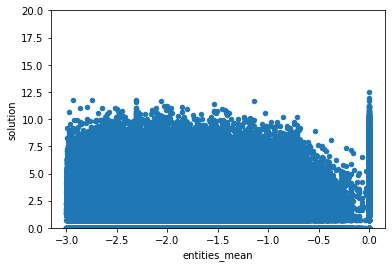

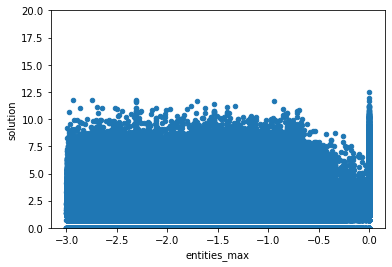

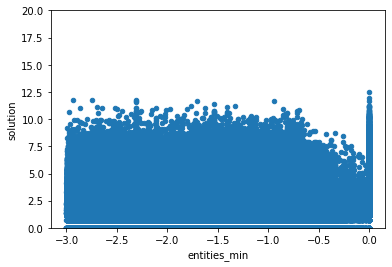

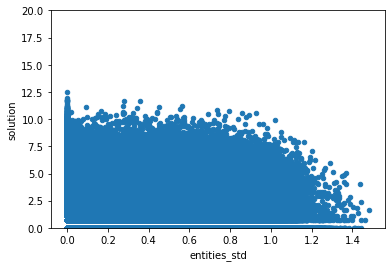

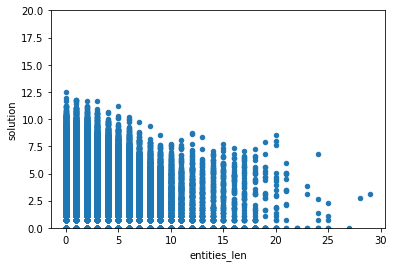

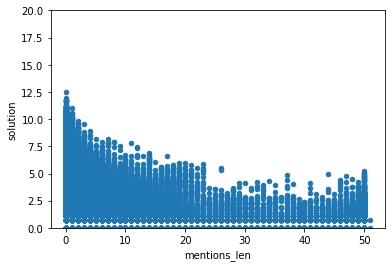

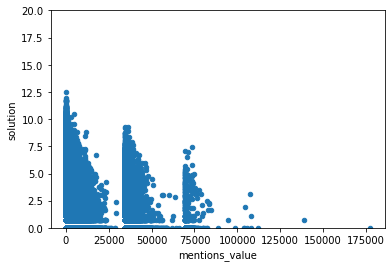

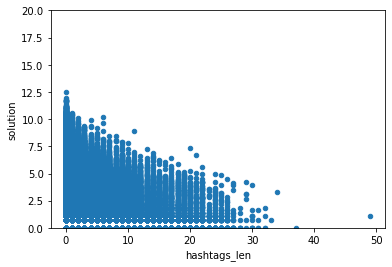

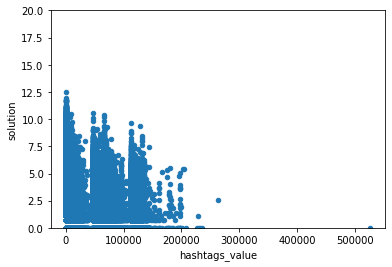

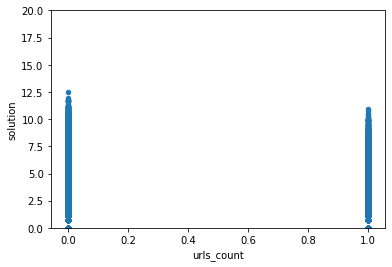

In [23]:
for var in used_feature:
    data = pd.concat([train_data['solution'], train_data[var]], axis=1)
    data.plot.scatter(x=var, y='solution', ylim=(0,20));

### timestamp

### followers

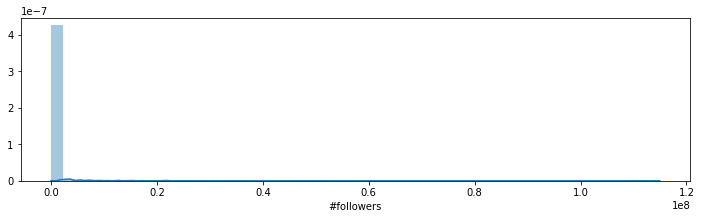

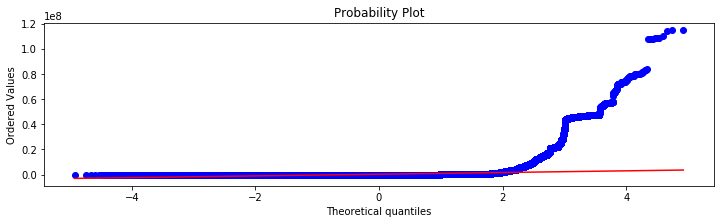

In [24]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['#followers']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['#followers'], plot=plt)

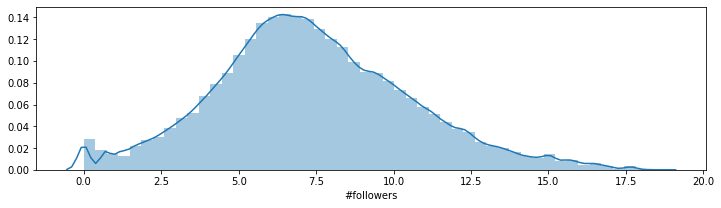

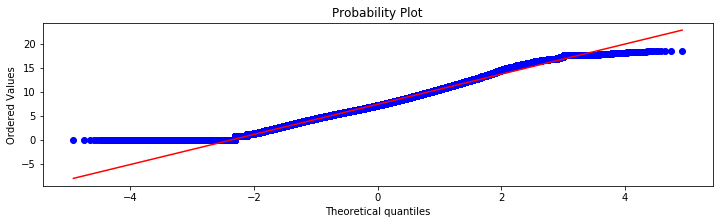

In [25]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['#followers'].map(lambda x : np.log(1 + x)));
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['#followers'].map(lambda x : np.log(1 + x)), plot=plt)

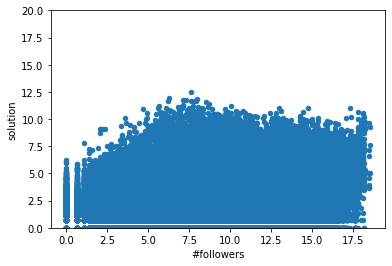

In [26]:
data = pd.concat([train_data['solution'], train_data['#followers'].map(lambda x : np.log(1 + x))], axis=1)
data.plot.scatter(x='#followers', y='solution', ylim=(0,20));

特征followers在取对数后展现出一定的正态分布,与solution的关系也稍微加强.

In [27]:
train_data['#followers_log'] = train_data['#followers'].map(lambda x : np.log(1 + x))

### friends

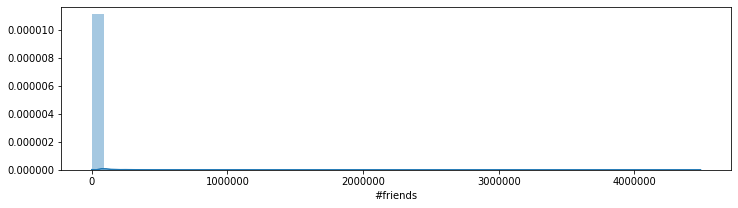

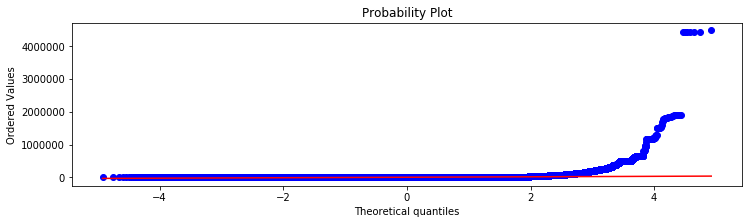

In [28]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['#friends']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['#friends'], plot=plt)

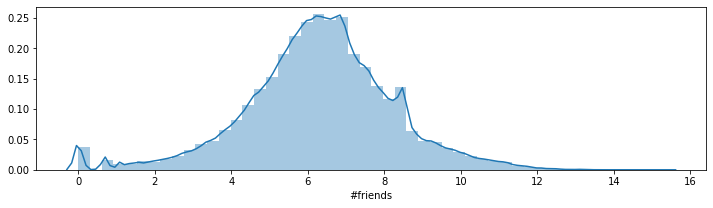

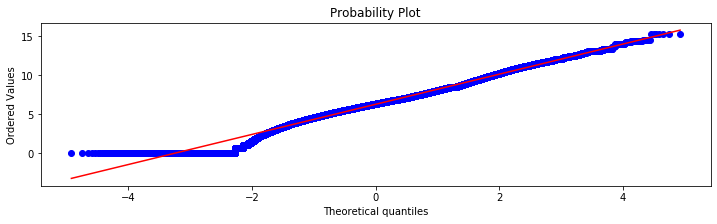

In [29]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['#friends'].map(lambda x : np.log(1 + x)));
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['#friends'].map(lambda x : np.log(1 + x)), plot=plt)

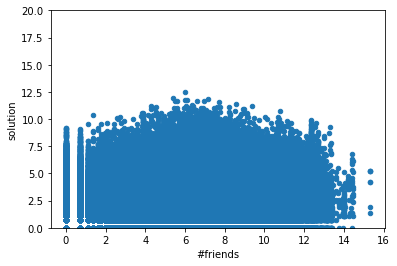

In [30]:
data = pd.concat([train_data['solution'], train_data['#friends'].map(lambda x : np.log(1 + x))], axis=1)
data.plot.scatter(x='#friends', y='solution', ylim=(0,20));

In [31]:
train_data['#friends_log'] = train_data['#friends'].map(lambda x : np.log(1 + x))

### favorites

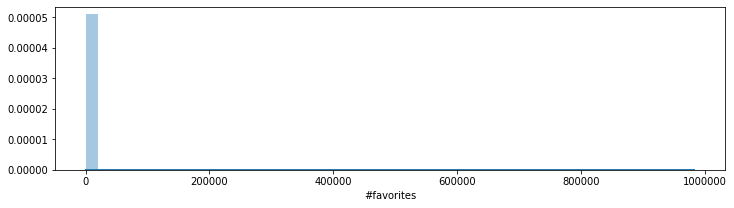

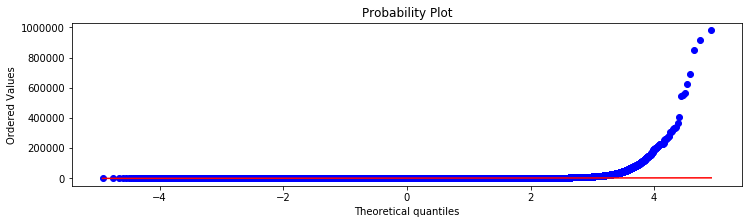

In [32]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['#favorites']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['#favorites'], plot=plt)

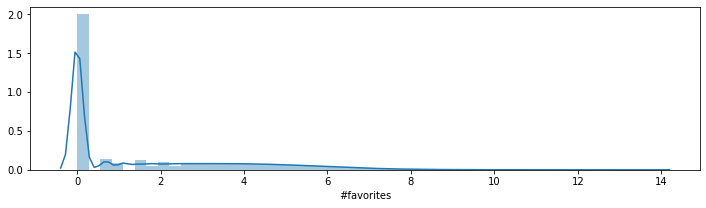

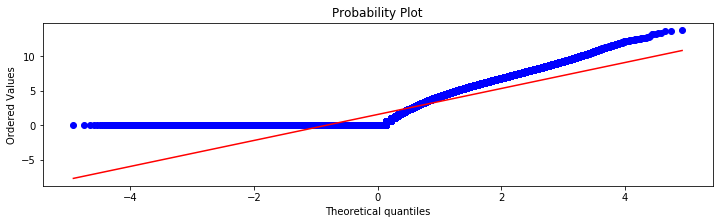

In [33]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['#favorites'].map(lambda x : np.log(1 + x)));
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['#favorites'].map(lambda x : np.log(1 + x)), plot=plt)

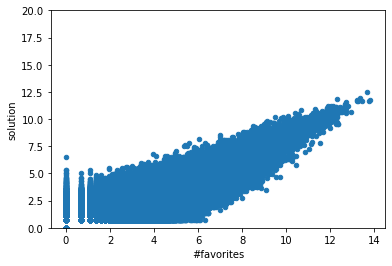

In [34]:
data = pd.concat([train_data['solution'], train_data['#favorites'].map(lambda x : np.log(1 + x))], axis=1)
data.plot.scatter(x='#favorites', y='solution', ylim=(0,20));

In [35]:
train_data['#favorites_log'] = train_data['#favorites'].map(lambda x : np.log(1 + x))

### sentiment_left

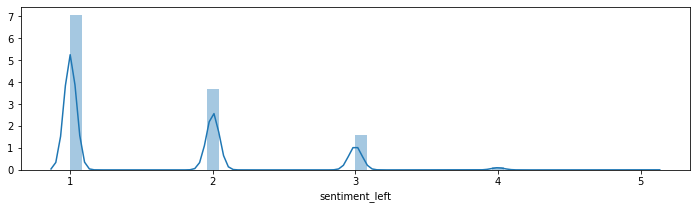

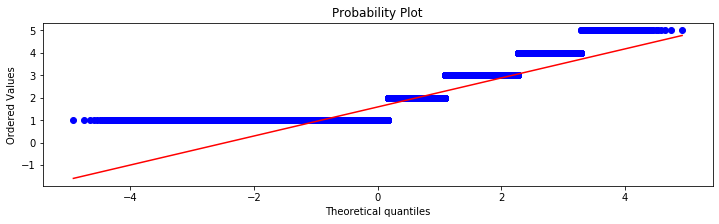

In [36]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['sentiment_left']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['sentiment_left'], plot=plt)

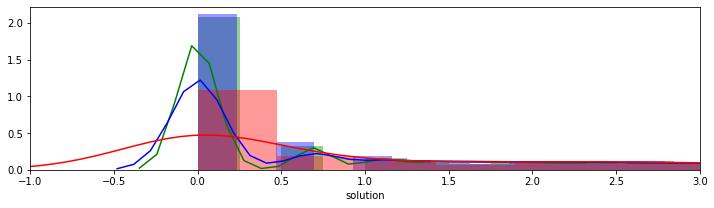

In [37]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
plt.xlim(-1,3)
sns.distplot(train_data.loc[train_data['sentiment_left'] == 1]['solution'], color="g");
sns.distplot(train_data.loc[train_data['sentiment_left'] == 3]['solution'], color="b");
sns.distplot(train_data.loc[train_data['sentiment_left'] == 5]['solution'], color="r");

### sentiment_right

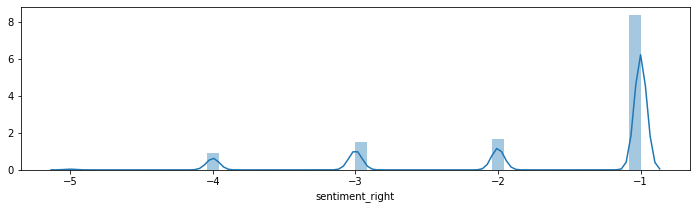

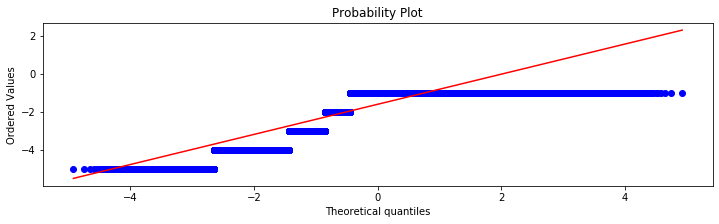

In [38]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['sentiment_right']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['sentiment_right'], plot=plt)

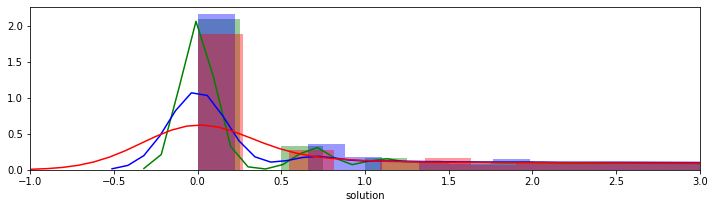

In [39]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
plt.xlim(-1,3)
sns.distplot(train_data.loc[train_data['sentiment_right'] == -1]['solution'], color="g");
sns.distplot(train_data.loc[train_data['sentiment_right'] == -3]['solution'], color="b");
sns.distplot(train_data.loc[train_data['sentiment_right'] == -5]['solution'], color="r");

### sentiment_sum

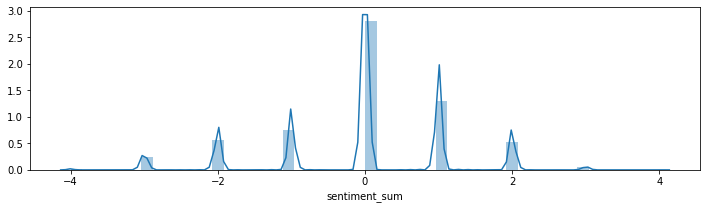

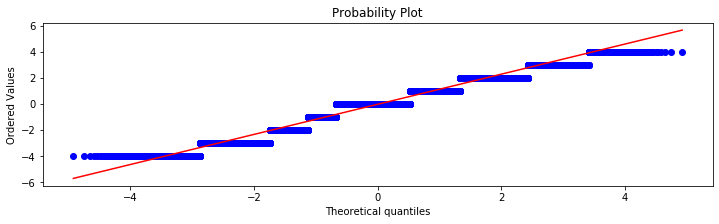

In [40]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['sentiment_sum']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['sentiment_sum'], plot=plt)

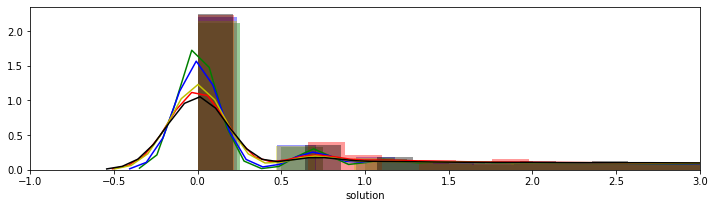

In [41]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
plt.xlim(-1,3)
sns.distplot(train_data.loc[train_data['sentiment_sum'] == 0]['solution'], color="g");
sns.distplot(train_data.loc[train_data['sentiment_sum'] == 1]['solution'], color="b");
sns.distplot(train_data.loc[train_data['sentiment_sum'] == 2]['solution'], color="r");
sns.distplot(train_data.loc[train_data['sentiment_sum'] == -1]['solution'], color="y");
sns.distplot(train_data.loc[train_data['sentiment_sum'] == -2]['solution'], color="k");

### sentiment_sumabs

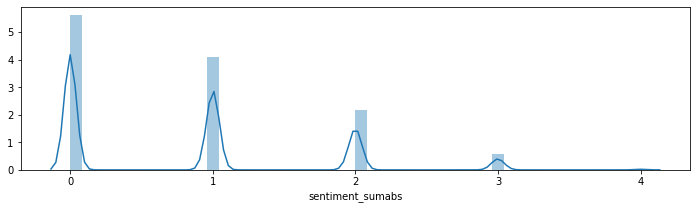

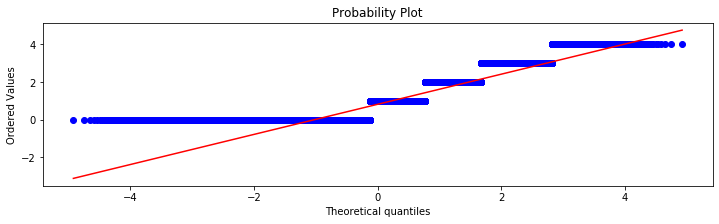

In [42]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['sentiment_sumabs']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['sentiment_sumabs'], plot=plt)

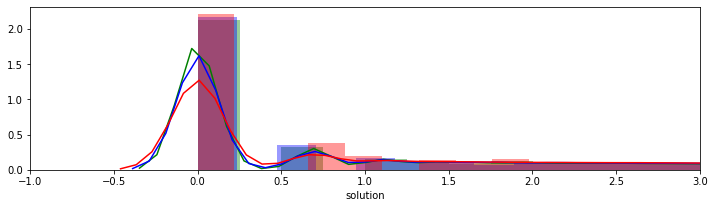

In [43]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
plt.xlim(-1,3)
sns.distplot(train_data.loc[train_data['sentiment_sumabs'] == 0]['solution'], color="g");
sns.distplot(train_data.loc[train_data['sentiment_sumabs'] == 1]['solution'], color="b");
sns.distplot(train_data.loc[train_data['sentiment_sumabs'] == 2]['solution'], color="r");

### sentiment_diff

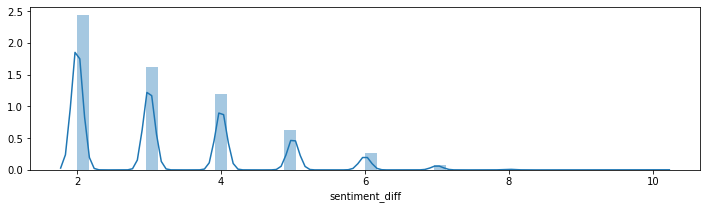

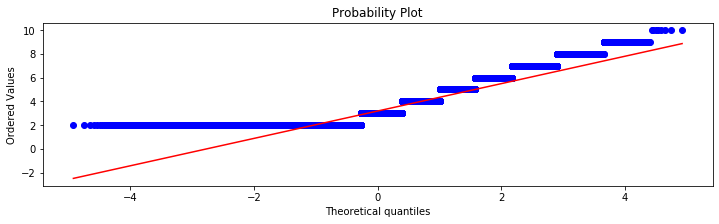

In [44]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['sentiment_diff']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['sentiment_diff'], plot=plt)

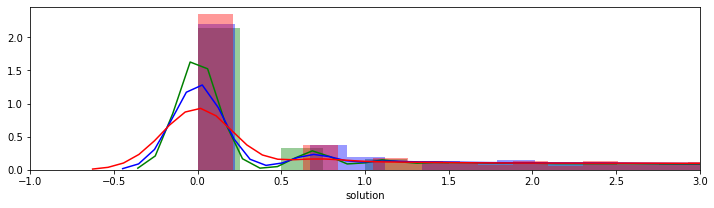

In [45]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
plt.xlim(-1,3)
sns.distplot(train_data.loc[train_data['sentiment_diff'] == 2]['solution'], color="g");
sns.distplot(train_data.loc[train_data['sentiment_diff'] == 4]['solution'], color="b");
sns.distplot(train_data.loc[train_data['sentiment_diff'] == 6]['solution'], color="r");

### sentiment_div

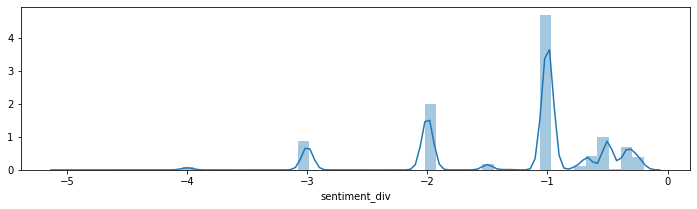

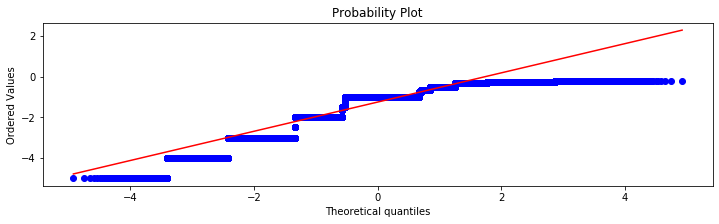

In [46]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['sentiment_div']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['sentiment_div'], plot=plt)

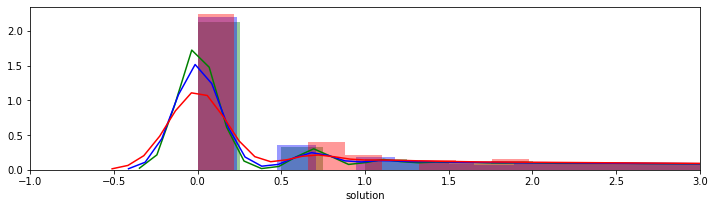

In [47]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
plt.xlim(-1,3)
sns.distplot(train_data.loc[train_data['sentiment_div'] == -1]['solution'], color="g");
sns.distplot(train_data.loc[train_data['sentiment_div'] == -2]['solution'], color="b");
sns.distplot(train_data.loc[train_data['sentiment_div'] == -3]['solution'], color="r");

### entities_mean

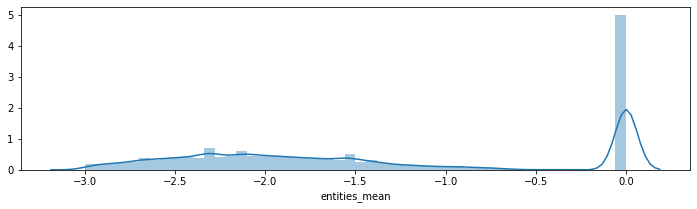

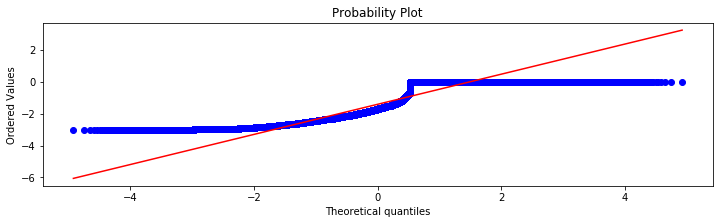

In [48]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['entities_mean']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['entities_mean'], plot=plt)

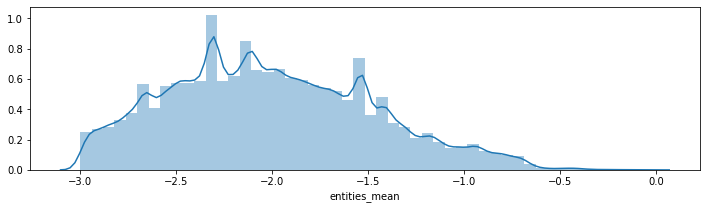

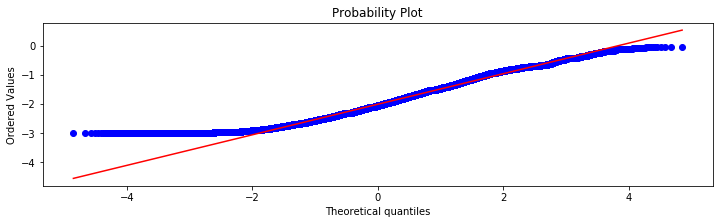

In [49]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data.loc[train_data['entities_mean'] < 0]['entities_mean']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data.loc[train_data['entities_mean'] < 0]['entities_mean'], plot=plt)

In [50]:
entities_mean_value = np.mean(train_data.loc[train_data['entities_mean'] < 0]['entities_mean'])
train_data['entities_mean_1'] = train_data['entities_mean'].replace(0, entities_mean_value)

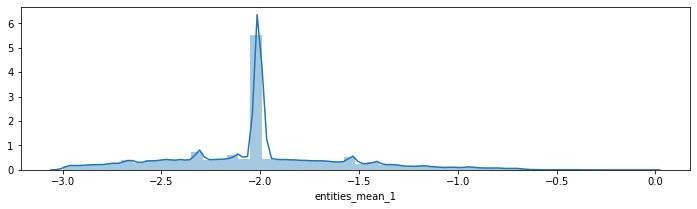

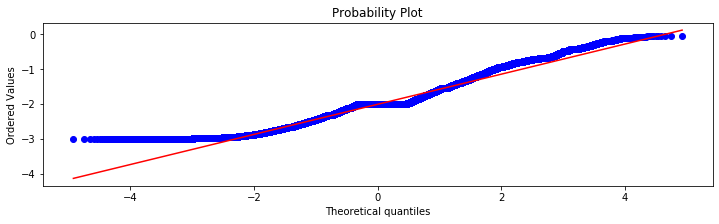

In [51]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['entities_mean_1']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['entities_mean_1'], plot=plt)

### entities_max

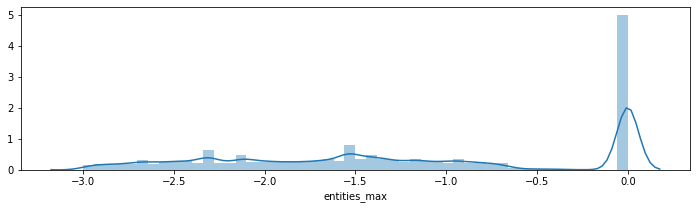

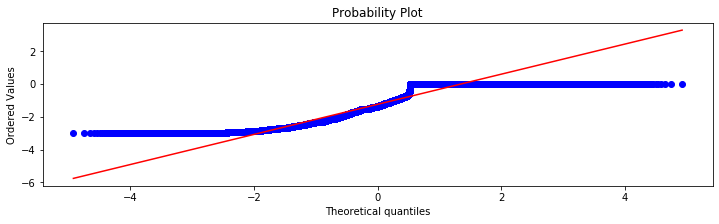

In [52]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['entities_max']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['entities_max'], plot=plt)

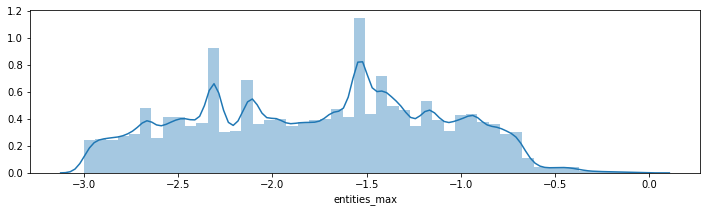

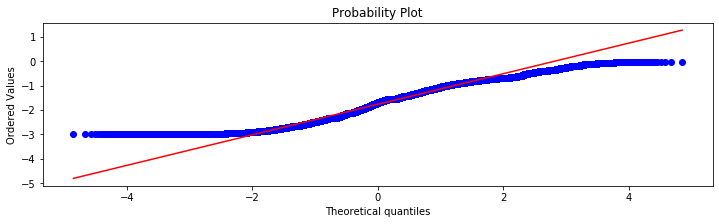

In [53]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data.loc[train_data['entities_max'] < 0]['entities_max']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data.loc[train_data['entities_max'] < 0]['entities_max'], plot=plt)

In [54]:
entities_max_value = np.mean(train_data.loc[train_data['entities_max'] < 0]['entities_max'])
train_data['entities_max_1'] = train_data['entities_max'].replace(0, entities_max_value)

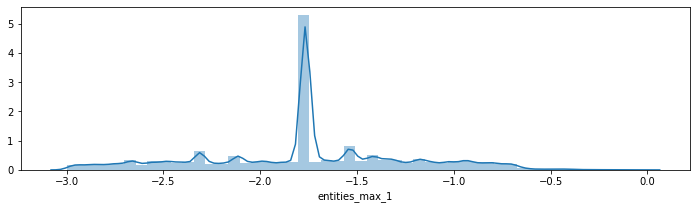

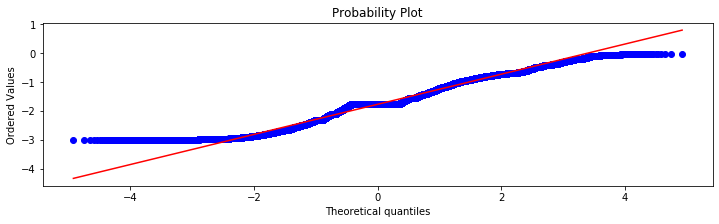

In [55]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['entities_max_1']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['entities_max_1'], plot=plt)

### entities_min

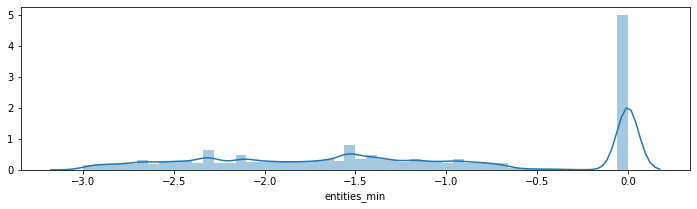

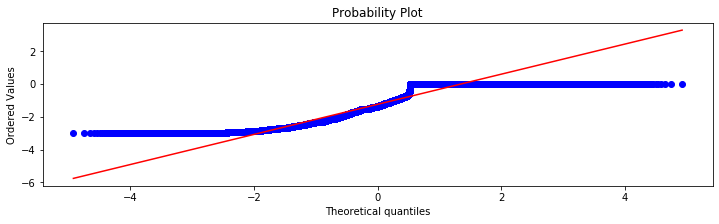

In [56]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['entities_min']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['entities_min'], plot=plt)

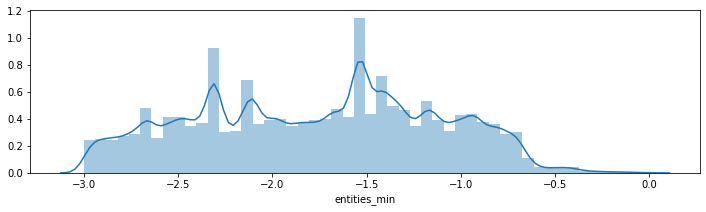

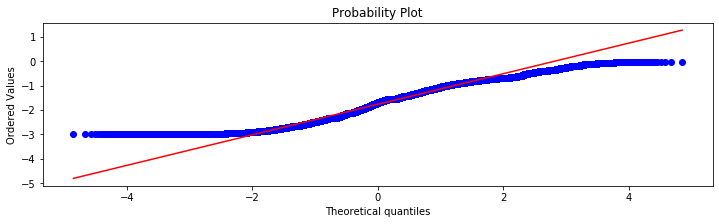

In [57]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data.loc[train_data['entities_min'] < 0]['entities_min']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data.loc[train_data['entities_min'] < 0]['entities_min'], plot=plt)

In [58]:
entities_min_value = np.mean(train_data.loc[train_data['entities_min'] < 0]['entities_min'])
train_data['entities_min_1'] = train_data['entities_min'].replace(0, entities_min_value)

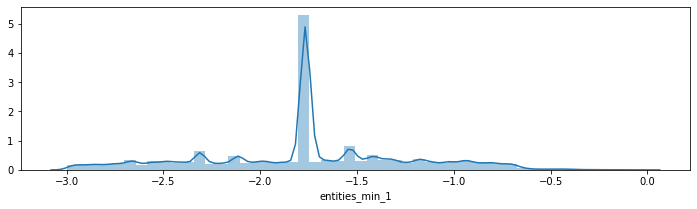

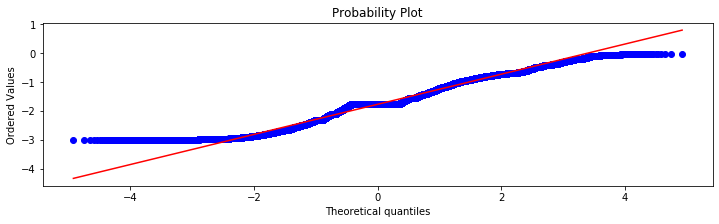

In [59]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['entities_min_1']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['entities_min_1'], plot=plt)

### entities_std

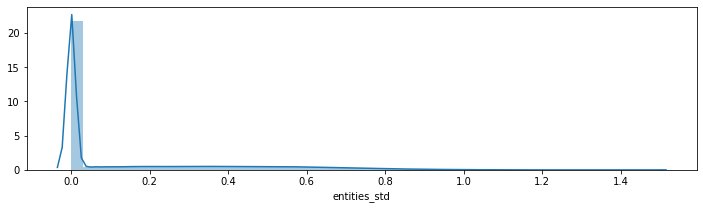

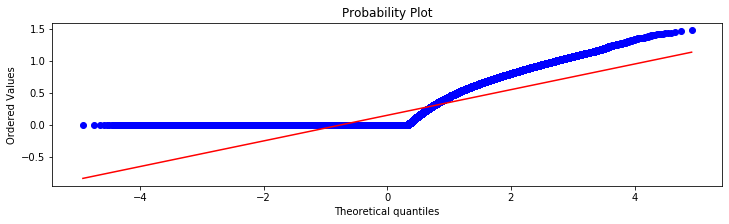

In [60]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['entities_std']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['entities_std'], plot=plt)

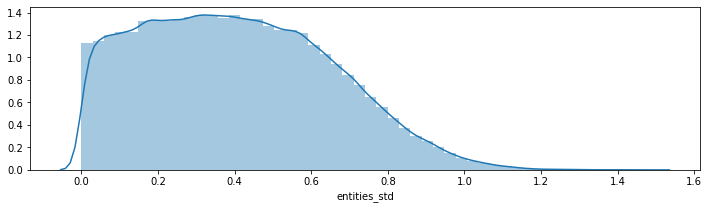

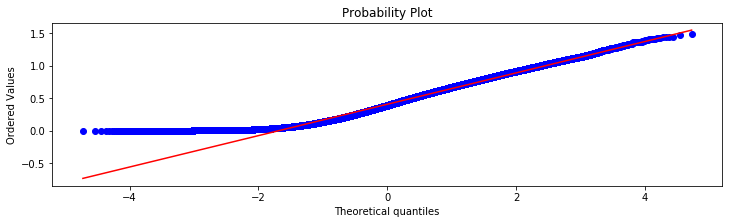

In [61]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data.loc[train_data['entities_std'] > 0]['entities_std']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data.loc[train_data['entities_std'] > 0]['entities_std'], plot=plt)

### entities_len

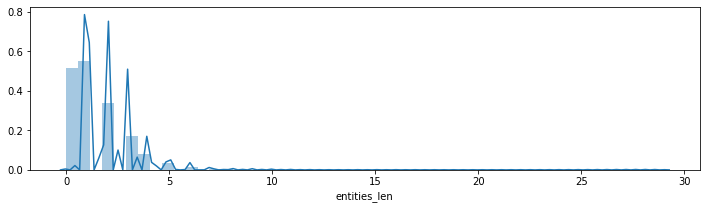

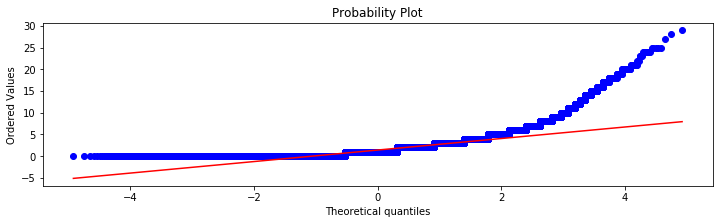

In [62]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['entities_len']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['entities_len'], plot=plt)

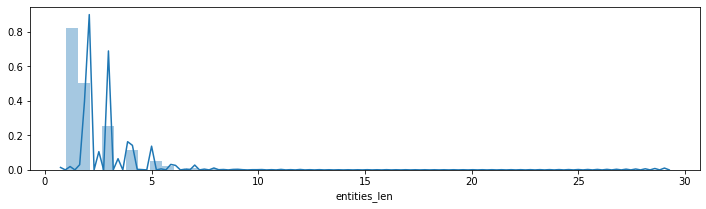

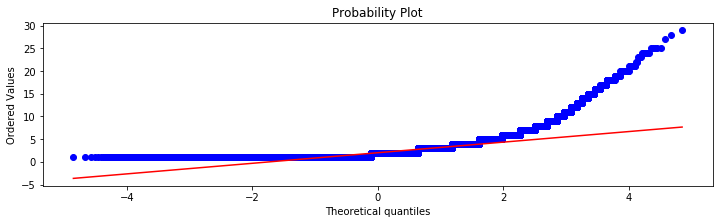

In [63]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data.loc[train_data['entities_len'] > 0]['entities_len']);
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data.loc[train_data['entities_len'] > 0]['entities_len'], plot=plt)

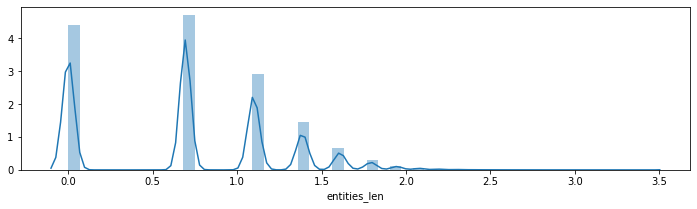

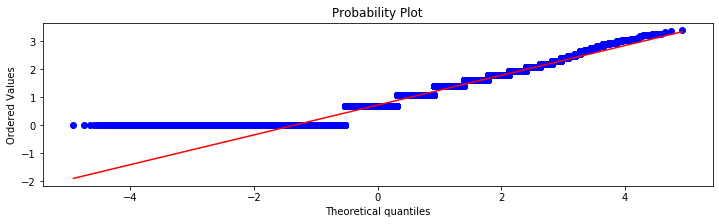

In [64]:
#histogram and normal probability plot
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data['entities_len'].map(lambda x : np.log(1 + x)));
f, ax = plt.subplots(figsize=(12, 3))
res = stats.probplot(train_data['entities_len'].map(lambda x : np.log(1 + x)), plot=plt)

In [65]:
train_data['entities_len_log'] = train_data['entities_len'].map(lambda x : np.log(1 + x))

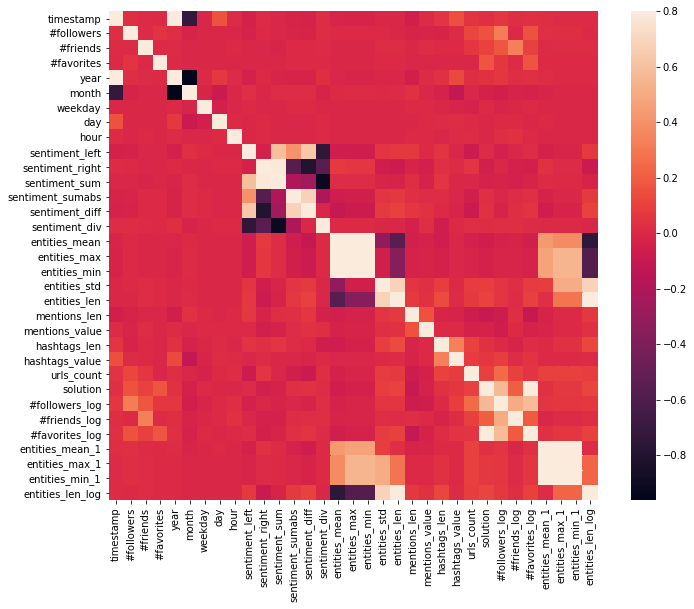

In [66]:
#correlation matrix
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

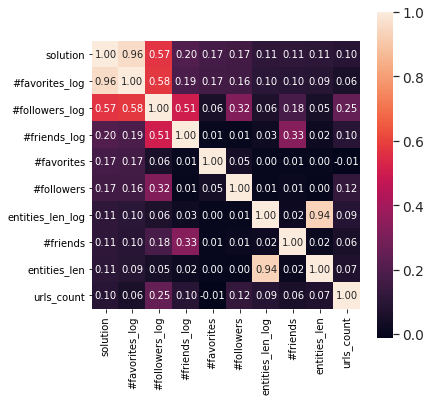

In [67]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'solution')['solution'].index
cm = np.corrcoef(train_data[cols].values.T)
f, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [68]:
NUM_OF_FOLDS = 5

In [69]:
def mse(preds, dmatrix):
    label = dmatrix.get_label()
    score = mean_squared_error(label, preds)
    return 'mse', score

In [70]:
used_feature = [
    'timestamp', 
    '#followers', 
    '#friends',
    '#favorites',
    'year', 'month', 'weekday', 'day', 'hour', 'sentiment_left',
    'sentiment_right', 'sentiment_sum', 'sentiment_sumabs',
    'sentiment_diff', 'sentiment_div', 'entities_mean', 'entities_max',
    'entities_min', 'entities_std', 'entities_len', 'mentions_len',
    'mentions_value', 'hashtags_len', 'hashtags_value', 'urls_count',
#     '#followers_log', 
#     '#friends_log',
#     '#favorites_log',
#     'entities_mean_1', 
#     'entities_max_1', 
#     'entities_min_1',
#     'entities_len_log'
]

In [71]:
y_train = train_data['solution']
X_train = train_data[used_feature]

In [72]:
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.333, random_state=0)

In [73]:
y_preds_fold = np.zeros((valid_x.shape[0], NUM_OF_FOLDS))

In [84]:
params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'gamma': 2,
        'min_child_weight': 2,
        'max_depth': 7,
        'lambda': 10,
        'subsample': 1,
        'colsample_bytree': 0.7,
        'eta': 0.1,
        'alpha': 0,
        'lambda': 0.05,
        'seed': 0,
        'nthread': 2
    }

In [85]:
skf = KFold(n_splits=NUM_OF_FOLDS, shuffle=True)
for n_fold, (train_index, val_index) in enumerate(skf.split(train_x, train_y)):
    dtrain = xgb.DMatrix(train_x.iloc[train_index, :], label=train_y.iloc[train_index])
    dval = xgb.DMatrix(train_x.iloc[val_index, :], label=train_y.iloc[val_index])

    xgb_model = xgb.train(
        params, dtrain, num_boost_round=10000, 
        evals=[(dtrain, 'train'), (dval, 'val')], feval = mse,
        verbose_eval=100, early_stopping_rounds=100
    )

#     xgb_model.save_model(TMP_PATH+'xgb_model_'+str(n_fold)+'.m')

    del dtrain, dval
    gc.collect()

    y_preds_fold[:, n_fold] = xgb_model.predict(
            xgb.DMatrix(valid_x), ntree_limit=xgb_model.best_iteration
            )

[0]	train-rmse:1.73398	val-rmse:1.73066	train-mse:3.00548	val-mse:2.99435
Multiple eval metrics have been passed: 'val-mse' will be used for early stopping.

Will train until val-mse hasn't improved in 100 rounds.
[100]	train-rmse:0.42762	val-rmse:0.43490	train-mse:0.18296	val-mse:0.18915
[200]	train-rmse:0.42228	val-rmse:0.43206	train-mse:0.17841	val-mse:0.18670
[300]	train-rmse:0.42072	val-rmse:0.43143	train-mse:0.17710	val-mse:0.18615
[400]	train-rmse:0.41955	val-rmse:0.43094	train-mse:0.17612	val-mse:0.18572
[500]	train-rmse:0.41919	val-rmse:0.43081	train-mse:0.17581	val-mse:0.18561
[600]	train-rmse:0.41906	val-rmse:0.43076	train-mse:0.17571	val-mse:0.18557
[700]	train-rmse:0.41890	val-rmse:0.43069	train-mse:0.17557	val-mse:0.18551
[800]	train-rmse:0.41862	val-rmse:0.43062	train-mse:0.17533	val-mse:0.18545
[900]	train-rmse:0.41823	val-rmse:0.43048	train-mse:0.17501	val-mse:0.18533
[1000]	train-rmse:0.41766	val-rmse:0.43027	train-mse:0.17453	val-mse:0.18515
Stopping. Best iteration:

In [86]:
mean_squared_error(valid_y, y_preds_fold.mean(axis=1))

0.1842966116064984

In [87]:
# xgb_model = xgb.Booster({'nthread': THREADS, 'seed': RANDOM_STATE})
# xgb_model.load_model('xgb_model_'+str(4)+'.m') # load data

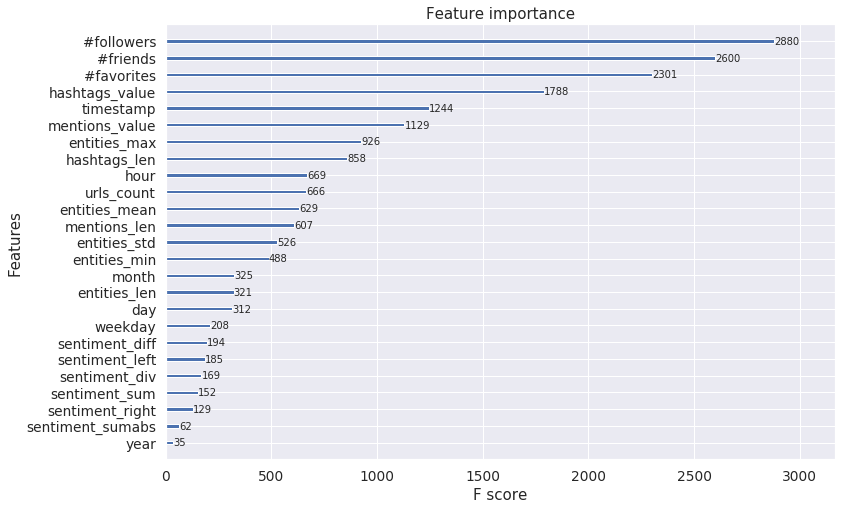

In [88]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
xgb.plot_importance(xgb_model, ax)

### favorites

In [ ]:
train_data.loc[train_data['solution']== 0].shape[0] / train_data.shape[0]

In [ ]:
data = pd.concat([train_data['solution'], train_data['#favorites']], axis=1)
data.plot.scatter(x='#favorites', y='solution', ylim=(0,20));

In [ ]:
f, ax = plt.subplots(figsize=(12, 3))
sns.distplot(train_data.loc[train_data['#favorites'] < 20]['#favorites']);

In [ ]:
train_data.loc[train_data['#favorites'] == 0].shape[0] / train_data.shape[0]

In [ ]:
train_data.loc[train_data['#favorites'] == 0]['solution'].value_counts()

In [ ]:
train_data.loc[train_data['#favorites'] != 0]['solution'].value_counts()

In [ ]:
df = train_data.loc[train_data['#favorites'] != 0]
data = pd.concat([df['solution'], df['#favorites']], axis=1)
data.plot.scatter(x='#favorites', y='solution', ylim=(0,20));

In [ ]:
train_data.loc[train_data['#followers'] == 0].shape[0] / train_data.shape[0]

In [ ]:
train_data.loc[train_data['#followers'] == 0]['solution'].value_counts()

In [ ]:
train_data.loc[train_data['#friends'] == 0].shape[0] / train_data.shape[0]

In [ ]:
train_data.loc[train_data['#friends'] == 0]['solution'].value_counts()

In [ ]:
train_data.loc[(train_data['#favorites'] == 0) & (((train_data['#followers'] != 0) | (train_data['#friends'] != 0)))]['solution'].value_counts()

### train, valid and test distribution

In [92]:
df_train = train_data[used_feature]
df_valid = X_valid[used_feature]
df_test = X_test[used_feature]

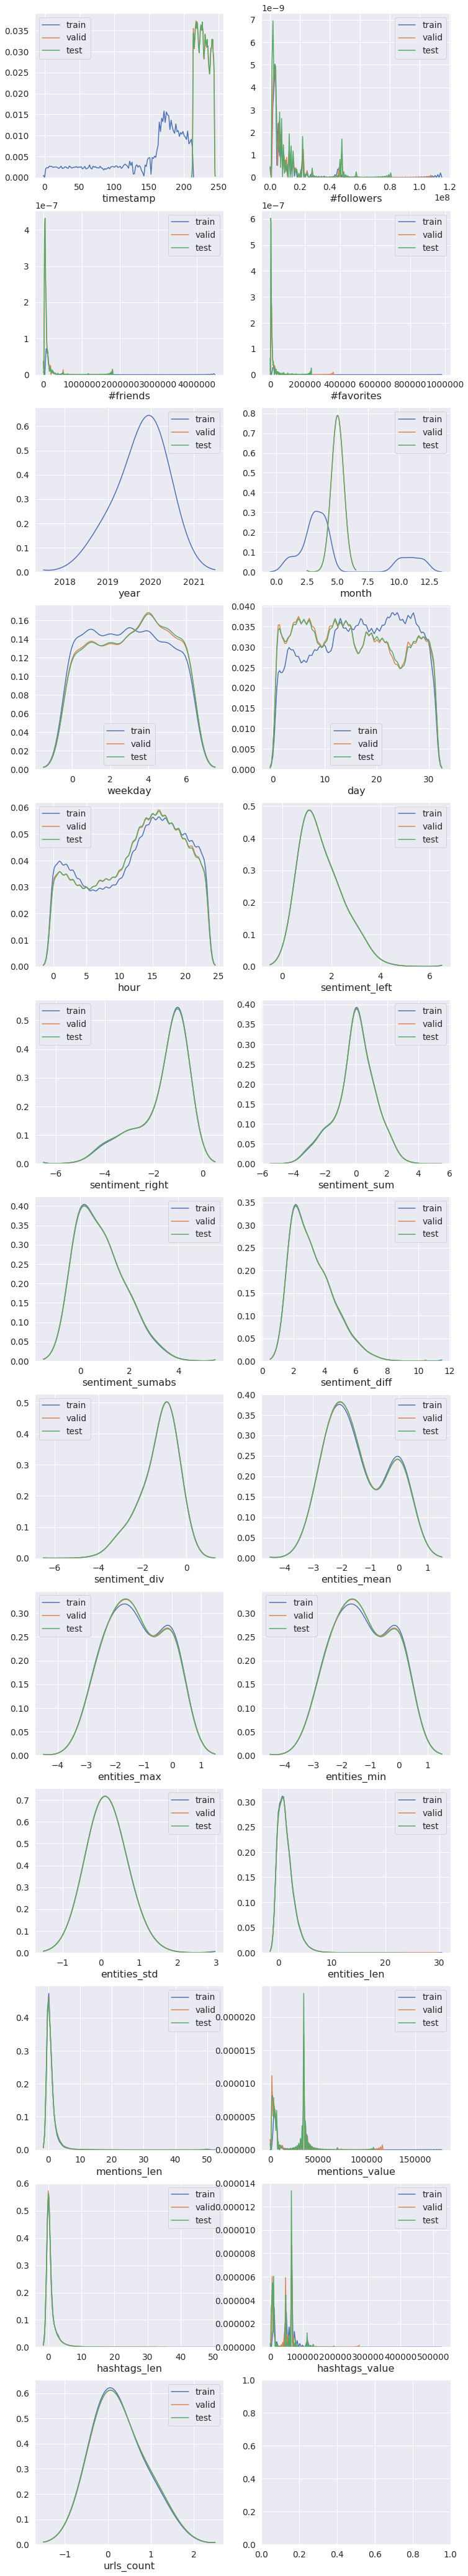

In [105]:
fig, ax = plt.subplots(len(used_feature) // 2 + 1, 2, figsize=(12, 3 * len(used_feature)))
for idx, feat in enumerate(used_feature):
    plt.subplot(len(used_feature) // 2 + 1, 2, idx + 1)
    sns.kdeplot(df_train[feat], bw=0.5, label='train')
    sns.kdeplot(df_valid[feat], bw=0.5, label='valid')
    sns.kdeplot(df_test[feat], bw=0.5, label='test')
    plt.xlabel(feat, fontsize=16)
plt.show()

### 特征选择

In [106]:
res = {'base': 0.18618269519650138, 'timestamp': 0.18629128331734518, '#followers': 0.1914735751046556, '#friends': 0.19252790198823733, '#favorites': 1.662311608705258, 'weekday': 0.18611264869911157, 'month': 0.18654361494227234, 'day': 0.1863411768599992, 'hour': 0.18822848469020392, 'sentiment_left': 0.18634361860387572, 'sentiment_right': 0.18636254312116984, 'sentiment_sum': 0.18644645459113612, 'sentiment_sumabs': 0.18601582151508647, 'sentiment_diff': 0.18655520748581, 'sentiment_div': 0.1860793999798138, 'entities_mean': 0.18609649604357942, 'entities_max': 0.18608308985098293, 'entities_min': 0.18636407464088434, 'entities_std': 0.18614182957207964, 'entities_len': 0.1864971598653537, 'mentions_len': 0.18650132742258899, 'mentions_value': 0.187843069278073, 'hashtags_len': 0.18625300372002052, 'hashtags_value': 0.18820532663021539, 'urls_count': 0.1929806935247141}

In [107]:
for key in res:
    if res[key] > 0.18618269519650138:
        print(key, ':', res[key], '--------- N')
    else:
        print(key, ':', res[key], '--------- Y')

base : 0.18618269519650138 --------- Y
timestamp : 0.18629128331734518 --------- N
#followers : 0.1914735751046556 --------- N
#friends : 0.19252790198823733 --------- N
#favorites : 1.662311608705258 --------- N
weekday : 0.18611264869911157 --------- Y
month : 0.18654361494227234 --------- N
day : 0.1863411768599992 --------- N
hour : 0.18822848469020392 --------- N
sentiment_left : 0.18634361860387572 --------- N
sentiment_right : 0.18636254312116984 --------- N
sentiment_sum : 0.18644645459113612 --------- N
sentiment_sumabs : 0.18601582151508647 --------- Y
sentiment_diff : 0.18655520748581 --------- N
sentiment_div : 0.1860793999798138 --------- Y
entities_mean : 0.18609649604357942 --------- Y
entities_max : 0.18608308985098293 --------- Y
entities_min : 0.18636407464088434 --------- N
entities_std : 0.18614182957207964 --------- Y
entities_len : 0.1864971598653537 --------- N
mentions_len : 0.18650132742258899 --------- N
mentions_value : 0.187843069278073 --------- N
hashtags_